<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-предобработка-данных" data-toc-modified-id="Загрузка-и-предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и предобработка данных</a></span></li><li><span><a href="#Оценка-корректности-проведения-теста." data-toc-modified-id="Оценка-корректности-проведения-теста.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Оценка корректности проведения теста.</a></span></li><li><span><a href="#Исследовательский-анализ-данных." data-toc-modified-id="Исследовательский-анализ-данных.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ данных.</a></span></li><li><span><a href="#Оценка-результатов-А-В-тестирования" data-toc-modified-id="Оценка-результатов-А-В-тестирования-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Оценка результатов А-В тестирования</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# A/B-тестирование

В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов. Наша задача — провести оценку результатов A/B-теста.

 Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.
## Загрузка и предобработка данных

In [1]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
sns.set_palette('muted')
from plotly import graph_objects as go
import plotly.express as px
import math as mth
from scipy import stats as st
import plotly.io as pio
pio.renderers.default = "png"

In [3]:
try:
    mk_events, events, new_users, participants = (pd.read_csv('ab_project_marketing_events.csv'),
                    pd.read_csv('final_ab_events.csv'),
                    pd.read_csv('final_ab_new_users.csv'),
                    pd.read_csv('final_ab_participants.csv'))
except:
    mk_events, events, new_users, participants = (pd.read_csv('/datasets/ab_project_marketing_events.csv'),
                    pd.read_csv('/datasets/final_ab_events.csv'),
                    pd.read_csv('/datasets/final_ab_new_users.csv'),
                    pd.read_csv('/datasets/final_ab_participants.csv')) 

In [4]:
mk_events.info()
mk_events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [5]:
events.info(),
events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [6]:
new_users.info(),
new_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [7]:
participants.info(),
participants.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


По информации о данных видим, что пропусков в данных нет. Приведем даты к типу datetime.

In [8]:
mk_events[['start_dt', 'finish_dt']] = mk_events[['start_dt', 'finish_dt']].apply(pd.to_datetime, errors='coerce')
events['event_dt'] = pd.to_datetime(events['event_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

In [9]:
mk_events.duplicated().sum()

0

In [10]:
events.duplicated().sum()

0

In [11]:
new_users.duplicated().sum()

0

In [12]:
participants.duplicated().sum()

0

На этапе предобработки данных мы изменили типы данных где это необходимо, пропусков и дубликатов не обнаружено.

## Оценка корректности проведения теста.

In [13]:
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

В данных видим информацию о двух A-В тестах. Нужно проверить пересечение пользователей между тестами.

In [14]:
dupl_users = participants.groupby('user_id').agg({'ab_test':'nunique'}).query('ab_test > 1')
print(f'{len(dupl_users)} пользователя участвуют в обоих A-B тестах, посмотрим как они распределены между группами теста.')

1602 пользователя участвуют в обоих A-B тестах, посмотрим как они распределены между группами теста.


In [15]:
r_s_test = participants.query('ab_test=="recommender_system_test"')
iet_a_list = participants.query('user_id in @dupl_users.index and ab_test=="interface_eu_test" and group=="A"')['user_id']
iet_b_list = participants.query('user_id in @dupl_users.index and ab_test=="interface_eu_test" and group=="B"')['user_id']
df = r_s_test.query('user_id in @iet_a_list').groupby('group')['user_id'].count().to_frame().rename(columns={'user_id':'iet_A'})
df['iet_B'] = (r_s_test.query('user_id in @iet_b_list').groupby('group')['user_id'].count().to_frame()
.rename(columns={'user_id':'iet_B'}))
df['all_users'] = r_s_test.groupby('group')['user_id'].count()
df['perc_A'] = round(df['iet_A']*100/df['all_users'],2)
df['perc_B'] = round(df['iet_B']*100/df['all_users'],2)
df

,iet_A,iet_B,all_users,perc_A,perc_B
group,,,,,
A,482,439,3824,12.60,11.48
B,337,344,2877,11.71,11.96


Пользователи группы А конкурирующего теста составляют 12.6 и 11.7% процентов груп А и В нашего теста, группы В - 11.48 и 11.96% соответственно. Распределение между группами равномерное, тоесть конкурирующий тест одинаково влиял на группы А и В нашего теста, что в итоге на отношение конверсий не должно сказатся. 

Проверим пересечение пользователей между группами теста.

In [16]:
dupl_users_rst = r_s_test.groupby('user_id').agg({'group':'nunique'}).query('group > 1')
print(f'{len(dupl_users_rst)} пользователей участвуют в обоих группах A-В теста.')

0 пользователей участвуют в обоих группах A-В теста.


Оставим в датафреймах events и new_users только участников нашего теста.

In [17]:
rs_list = r_s_test['user_id'].tolist()
events = events.query('user_id in @rs_list')
new_users = new_users.query('user_id in @rs_list')

Проверим датасеты на соответствие дате запуска теста 2020-12-07.

In [18]:
events['event_dt'].min()

Timestamp('2020-12-07 00:05:57')

In [19]:
new_users['first_date'].min()

Timestamp('2020-12-07 00:00:00')

Даты соответствуют. Проверим датасет на соответствие дате остановки набора новых пользователей 2020-12-21.

In [20]:
new_users['first_date'].max()

Timestamp('2020-12-21 00:00:00')

Проверим датасет на соответствие дате остановки 2021-01-04.

In [21]:
events['event_dt'].max()

Timestamp('2020-12-30 12:42:57')

Дата окончания теста не соответствует, в данных не хватает информации за 4 дня. Проверим аудиторию теста, должно быть 15% новых пользователей из региона ЕU.

In [22]:
data = r_s_test.merge(new_users, on='user_id', how='left')
print(data.query('region=="EU"')['user_id'].count()*100/new_users.query('region=="EU"')['user_id'].count(),
      '% новых пользователей из региона ЕU.')

100.0 % новых пользователей из региона ЕU.


In [23]:
nu_region = new_users['region'].value_counts().to_frame()
nu_region['percent'] = round(nu_region['region']*100/nu_region['region'].sum(),2)
nu_region

,region,percent
EU,6351,94.78
N.America,223,3.33
APAC,72,1.07
CIS,55,0.82


Невозможно обеспечить заявленные в ТЗ 15% новых пользователей из региона EU, так как 95% всех новых пользователей из этого региона.

In [24]:
print(f'Количество участников теста {len(data)}.')

Количество участников теста 6701.


Количество участников теста соответствует ожидаемому количеству в 6000 и даже его превышает. Проверим совпадение теста и маркетинговых событий.

In [25]:
(mk_events.
 query('("2021-01-04"> start_dt >="2020-12-07") or  ("2021-01-04"> finish_dt >="2020-12-07") or ((start_dt <="2020-12-07") and (finish_dt>="2021-01-04"))'))

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Проведение A-B теста совпадает с временем проведения Christmas&New Year Promo и CIS New Year Gift Lottery это безусловно повлияет на конверсию, на обе группы в равной мере. Попробуем отследить новых прользователей которые пришли во время проведения промоакции.

In [26]:
print('Во время промоакции пришло',len(data.query('"2021-01-07">first_date>="2020-12-25"')),'новых пользователей.')

Во время промоакции пришло 0 новых пользователей.


In [27]:
data.groupby('group')['user_id'].count()

group
A    3824
B    2877
Name: user_id, dtype: int64

In [28]:
round((data.query('group=="A"')['user_id'].count()-data.query('group=="B"')['user_id'].count())*100/len(data),2)

14.13

Пользователи распределены между группами не равномерно, в группе А на 14% больше пользователей. Посмотрим есть ли пользователи которые не совершили ни одного события.

In [29]:
data = data.merge(events, on='user_id', how='left')

In [30]:
no_events_list = data.groupby('user_id')['event_name'].nunique().to_frame().query('event_name==0').index
print(len(data.query('user_id in @no_events_list')),
      'пользователей не совершили ни одного события. Посмотрим на распределение таких пользователей по группам.')

3026 пользователей не совершили ни одного события. Посмотрим на распределение таких пользователей по группам.


In [31]:
data_no_events= (data.query('user_id in @no_events_list')
                  .groupby('group')['user_id'].count().to_frame()
                  .rename(columns={'user_id':"no_events"}))
data_no_events['all_users'] = data.groupby('group')['user_id'].nunique()
data_no_events['percent'] = round(data_no_events['no_events']*100/data_no_events['all_users'],2)
data_no_events

,no_events,all_users,percent
group,,,
A,1077,3824,28.16
B,1949,2877,67.74


В группе А 28% процентов пользователей не активны, в группе B - 67%.

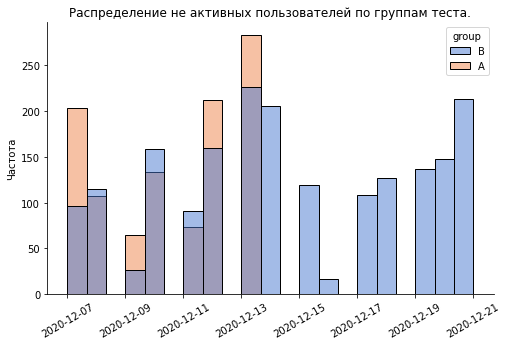

In [32]:
plt.figure(figsize=(8,5))
sns.histplot(data=data.query('user_id in @no_events_list'), x='first_date', hue='group')
plt.xticks(rotation=30)
plt.title('Распределение не активных пользователей по группам теста.')
plt.xlabel(None)
plt.ylabel('Частота')
sns.despine()

Видим, что первую неделю в обоих группах появлялись не активные пользователи, после 2020-12-13 не активные пользователи появляются только в группе В. Очень похоже на технический сбой в записи логов, в группе А его обнаружили и устранили, а в группе В, всвязи с внедрением улучшенной рекомендательной системы не смогли. Распределение не активных пользователей точно не похоже на естественную конверсию, потому таких пользователей прийдется отфильтровать.

In [33]:
data = data.query('user_id not in @no_events_list')

Отсечем события которые произошли позднее 14-ти дней с момента регистрации в системе.

In [34]:
data['lifetime'] = (data['event_dt']-data['first_date']).dt.days
data = data.query('lifetime <= 14')
data.groupby('group')['user_id'].nunique()

group
A    2747
B     928
Name: user_id, dtype: int64

In [35]:
print('Распределение по группам стало еще более не равномерным - в группе А на',
      round((data.query('group=="A"')['user_id'].count()-data.query('group=="B"')['user_id'].count())*100/len(data),2),
      '% пользователей больше.')
print(f'Количество участников теста составило {data.user_id.nunique()} и более не соответствует ожидаемому показателю в 6000.')
print('Всего ',round(data.query('region=="EU"')['user_id'].nunique()*100/new_users.query('region=="EU"')['user_id'].count(),2),
      '% новых пользователей из региона ЕU.')

Распределение по группам стало еще более не равномерным - в группе А на 57.43 % пользователей больше.
Количество участников теста составило 3675 и более не соответствует ожидаемому показателю в 6000.
Всего  54.81 % новых пользователей из региона ЕU.


В итоге:
- Часть участников теста участвует в конкурирующем тесте, их доля разделена равномерно между группами надеемся, что они повлияли на обе группы в одинаковой мере.
- Дата окончания теста не соответствует, в данных не хватает информации за 4 дня.
- Проведение A-B теста совпадает с временем проведения Christmas&New Year Promo и CIS New Year Gift Lottery, это безусловно повлияет на конверсию, на обе группы в равной мере. 
- Распределение по группам не равномерное - в группе А на 57.62 % пользователей больше.
- Количество участников теста составило 3675 и более не соответствует заложеному в ТЗ показателю в 6000.
- Всего  54,81 % новых пользователей из региона ЕU, что не соответствует заложеному в ТЗ показателю 15%.

А-В тест не соответствует техническому заданию, это может негативно повлиять на его результат.

## Исследовательский анализ данных.


In [36]:
print(f'В среднем на пользователя приходится {round(data.event_name.count()/data.user_id.nunique())} событий.')
print(f'В среднем на пользователя из группы А приходится' , 
      round(data.query('group=="A"').event_name.count()/data.query('group=="A"').user_id.nunique()), 'событий.')
print(f'В среднем на пользователя из группы B приходится' , 
      round(data.query('group=="B"').event_name.count()/data.query('group=="B"').user_id.nunique()), 'событий.')

В среднем на пользователя приходится 7 событий.
В среднем на пользователя из группы А приходится 7 событий.
В среднем на пользователя из группы B приходится 6 событий.


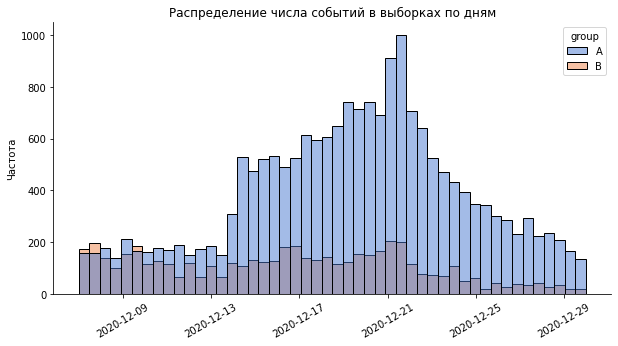

In [37]:
plt.figure(figsize=(10,5))
sns.histplot(data=data, x='event_dt', hue='group')
plt.xticks(rotation=30)
plt.title('Распределение числа событий в выборках по дням')
plt.xlabel(None)
plt.ylabel('Частота')
sns.despine()

В группе В относительно равномерное распределение событий в выборках по дням, в группе А картина была аналогична группе В, но после 2020-12-13 видим резкий рост количества событий с пиком в районе 2020-12-21, что соответсвует сезонному увеличению покупок всвязи с Рождественскими праздниками.

Раннее мы выяснили, что после 2020-12-13 в группе А пропали пользователи с нулевым количеством событий, то есть распределение еще раз подтверждает версию о техничесокм сбое в записи данных.

В воронке видим 4 события: 
1. login - регистрация;
2. product_page - просмотр карточек товаров;
3. product_cart - просмотр корзины;
4. purchase - покупка.

Посмотрим сколько пользователей соврешили каждое из этих событий

In [38]:
data_a = (data.query('group=="A"').groupby('event_name').agg({'user_id':'nunique'})
            .rename(columns={'user_id':'users'})).reset_index()

data_a1=data_a.copy()
data_a1.iloc[1,:],data_a1.iloc[2,:]=data_a.iloc[2,:],data_a.iloc[1,:]
data_a1

,event_name,users
0,login,2747
1,product_page,1780
2,product_cart,824
3,purchase,872


In [39]:
data_b = (data.query('group=="B"').groupby('event_name').agg({'user_id':'nunique'})
            .rename(columns={'user_id':'users'})).reset_index()

data_b1=data_b.copy()
data_b1.iloc[1,:],data_b1.iloc[2,:]=data_b.iloc[2,:],data_b.iloc[1,:]
data_b1

,event_name,users
0,login,927
1,product_page,523
2,product_cart,255
3,purchase,256


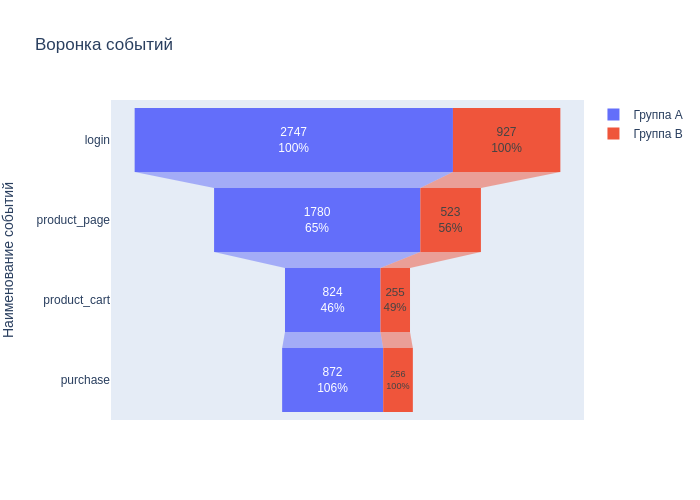

In [40]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа A',
    y = data_a1['event_name'],
    x = data_a1['users'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'Группа B',
    orientation = "h",
    y = data_b1['event_name'],
    x = data_b1['users'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.update_layout(title='Воронка событий', 
                 yaxis_title='Наименование событий')
fig.show()

В обоих группах больше всего пользователей мы теряем при переходе от регистрации к просмотру карточек товара.
От регистрации до успешной оплаты в группе А доходят около 14% пользователей, в группе В -13%.
Просмотр корзины совершают меньше пользователей чем покупку, скорее всего сушествует схема покупки товара минуя корзину, наподобии кнопки быстрой покупки в карточке товара.

Ожидаемый эффект группа В не показала:
- конверсия в просмотр карточек товаров — событие product_page в группе В на 9% ниже, чем в группе А.
- конверсия в просмотры корзины — product_cart в группе В на 3% выше группы А
- конверсия в покупки — purchase (этот показатель целесообразно рассматривать в отношении от общего количества участников, так как не все покупатели прошли этап добавления товаров в корзину) в группе B на 1% ниже, чем в группе А.

## Оценка результатов А-В тестирования

В соответствии с воронкой событий ожидаемый эффект, что за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%, группа В не показала. Но необходимо подтвердить, что разница является статистически значимой. Так как мы будем сравнивать доли, применим z-критерий. Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применим метод Шидака.  

In [41]:
values = (data.pivot_table(index='event_name', values='user_id', columns='group', aggfunc='nunique')
.reset_index())
values['total'] = values['A']+ values['B']
values_1=values.copy()
values_1.iloc[1,:],values_1.iloc[2,:]=values.iloc[2,:],values.iloc[1,:]
values_1

group,event_name,A,B,total
0,login,2747,927,3674
1,product_page,1780,523,2303
2,product_cart,824,255,1079
3,purchase,872,256,1128


In [42]:
group = data.groupby('group')['user_id'].nunique()
group

group
A    2747
B     928
Name: user_id, dtype: int64

Обозначим функцию для подсчета z-критерия.

In [43]:
def z_critery(values, trials, col1, col2):
    for i in range(1, 4):
        # критический уровень статистической значимости  
        alpha = 0.05
        # количество сравнений
        m = 3
        # новый уровень значимости
        alpha_m =  1 - (1 - alpha)**(1/m)
        
        successes = np.array([values.loc[i, col1], values.loc[i, col2]])  
        
        # пропорция успехов в первой группе:
        p1 = successes[0]/trials[0]    
        
        # пропорция успехов во второй группе:
        p2 = successes[1]/trials[1]   
        
        # пропорция успехов в комбинированном датасете:
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])   
        
        # разница пропорций в датасетах
        difference = p1 - p2    
        
        #считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))   
        
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)   
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2  
         
        print('{} p-значение: {}'.format(values['event_name'][i], p_value))
        if p_value < alpha_m:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print('---------------------------------------------------------------------------------')            

Проверим, есть ли разница между выборками А и В при помощи z-критерия. Сформулируем гипотезы:

Н0: Между долями нет статистически значимой разницы;
Н1: Между долями есть статистически значимая разница.

In [44]:
 z_critery(values, group, 'A', 'B')

product_cart p-значение: 0.14534814557238196
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------
product_page p-значение: 4.310980554755872e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница
---------------------------------------------------------------------------------
purchase p-значение: 0.017592402663314743
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
---------------------------------------------------------------------------------


В соответствии с z-критерием:

- конверсия в просмотр карточек товаров (событие product_page) в группе В на 9% ниже, чем в группе А и эта разница является статистически значимой.
- конверсия в просмотры корзины (product_cart) в группе В на 3% выше группы А и эта разница не является статистически значимой.
- конверсия в покупки (purchase) в группе B на 1% ниже, чем в группе А и эта разница является статистически значимой.

Проверка z-критерием подтвердила, что внедрение улучшенной рекомендательной системы ожидаемых результатов не показало.

## Выводы

Цель анализа — провести оценку результатов A/B-теста.

В обоих группах больше всего пользователей мы теряем при переходе от регистрации к просмотру карточек товара. От регистрации до успешной оплаты в группе А доходят около 14% пользователей, в группе В -13%. Просмотр корзины совершают меньше пользователей чем покупку, скорее всего существует схема покупки товара минуя корзину, на подобии кнопки быстрой покупки в карточке товара.

В соответствии с воронкой событий и z-критерием:
- конверсия в просмотр карточек товаров (событие product_page) в группе В на 9% ниже, чем в группе А и эта разница является статистически значимой.
- конверсия в просмотры корзины (product_cart) в группе В на 3% выше группы А и эта разница не является статистически значимой.
- конверсия в покупки (purchase) в группе B на 1% ниже, чем в группе А и эта разница является статистически значимой.

Проверка z-критерием подтвердила, что внедрение улучшенной рекомендательной системы ожидаемых результатов не принесло. Но стоит учесть, что А-В тест проведен не в соответствии с ТЗ, а именно: 
- Дата окончания теста не соответствует, в данных не хватает информации за 4 дня.
- Проведение A-B теста совпадает с временем проведения Christmas&New Year Promo и CIS New Year Gift Lottery, это безусловно повлияет на конверсию, на обе группы в равной мере.
- Распределение по группам не равномерное - в группе А на 57.62 % пользователей больше.
- Количество участников теста составило 3675 и более не соответствует заложеному в ТЗ показателю в 6000.
- Всего 54,81 % новых пользователей из региона ЕU, что не соответствует заложеному в ТЗ показателю 15%.

**А-В тест не соответствует техническому заданию, и это могло негативно повлиять на его результат.**